### Libraries

In [1]:
# import required libraries
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import seaborn as sns

### Reading shots data

In [2]:
league_names = os.listdir('data/')[:-1]
shots_dict = {}
all_shots = pd.DataFrame()
for league in league_names:
    # read shots for each league
    shots = pd.read_csv('data/' + league + '/shots.csv')
    shots['tag_id'] = shots['tag_id'].apply(ast.literal_eval)
    shots['tag_name'] = shots['tag_name'].apply(ast.literal_eval)
    
    # map team ids and player ids to corresponding names
    player_names = pd.read_csv('data/' + league + '/player_names.csv')
    team_names = pd.read_csv('data/' + league + '/team_names.csv').loc[:, ['team_id', 'team_name_short']]
    shots = shots.merge(player_names, on = 'player_id', how = 'left') \
                 .merge(team_names, on = 'team_id', how = 'left')
    
    # classify each shot as 'goal' = 1 and 'no goal' = 0
    shot_outcomes = shots['tag_id'].apply(lambda x: 1 if 101 in x else 0)
    shots['outcome'] = shot_outcomes
    
    all_shots = pd.concat([all_shots, shots])
    # save to dictionary
    shots_dict[league] = shots
    
all_shots = all_shots.reset_index(drop = True)

### Shots in each league

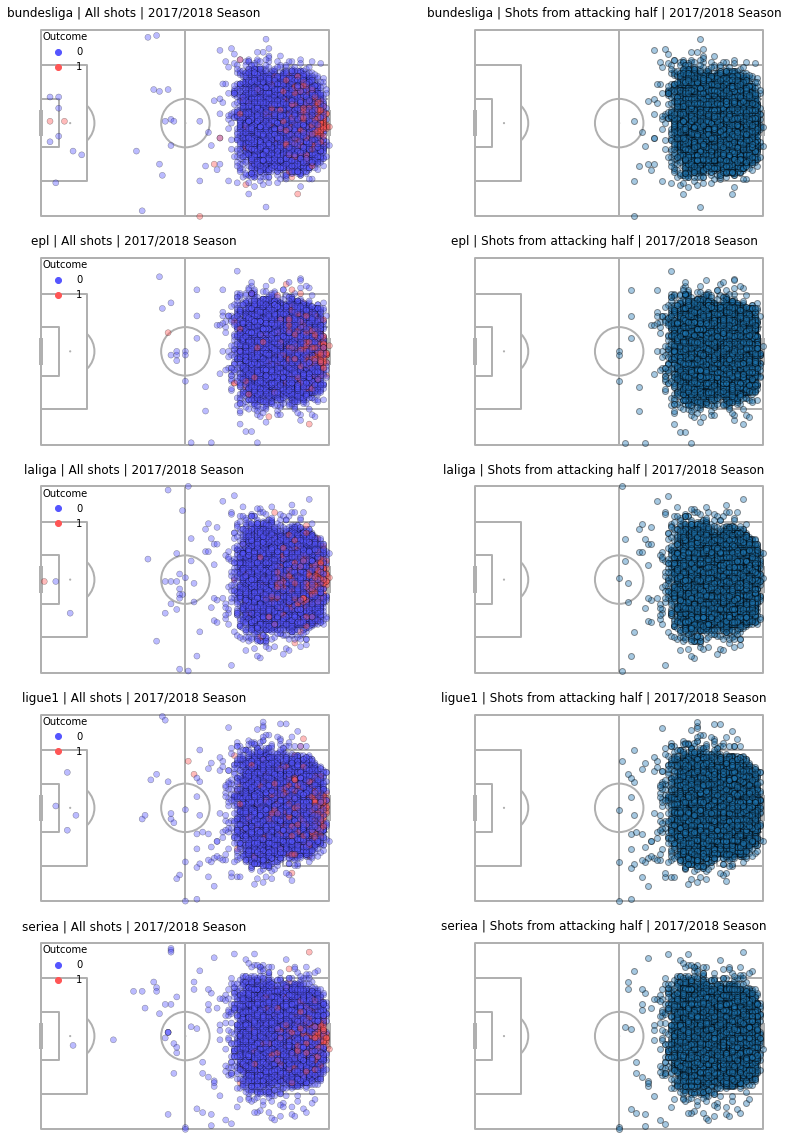

In [3]:
# Visual shots on Pitch
pitch = Pitch(pitch_type='wyscout')  
fig, ax = pitch.draw(nrows = 5, ncols = 2, figsize=(14, 16))

for i, league in enumerate(league_names):
        sns.scatterplot(data = shots_dict[league], x = 'x_start', y = 'y_start', ax = ax[i, 0], 
                        hue = 'outcome', palette = 'seismic', edgecolor = 'black', alpha = 0.4)

        ax[i, 0].legend(title = 'Outcome', frameon = False, loc = 'upper left')

        ax[i, 0].set_title(league + ' | All shots | 2017/2018 Season', x = 0.33, y = 1)


        # dataset with filtered out shots
        shots = shots_dict[league]
        own_half_shots = ((shots['x_start'] > 0) & (shots['x_start'] < 50) &  
                  (shots['y_start'] < 100) & (shots['y_start'] > 0))
        shots = shots[~own_half_shots]

        ax[i, 1].scatter(shots['x_start'], shots['y_start'], edgecolor = 'black', alpha = 0.4)
        ax[i, 1].set_title(league + ' | Shots from attacking half | 2017/2018 Season', x = 0.45, y = 1)

plt.show()

91 shots from own half are removed from the dataset. Although the direction of play is from left to right, it means that there are too many shots (8 !) from the penalty area of attacking team. Since both teams attack in the same direction, this could be a result of unflipped coordinate when tagging some of attacking team shots. In addition, even if this is a shot, these can largely skew model results. We will evaluate the impact of other outliers that are also present in the right half of the field when evaluating model.

In [4]:
own_half_shots = ((all_shots['x_start'] > 0) & (all_shots['x_start'] < 50) &  
                  (all_shots['y_start'] < 100) & (all_shots['y_start'] > 0))
all_shots = all_shots[~own_half_shots]

In [5]:
all_shots.shape

(40370, 17)

array([<AxesSubplot:title={'center':'outcome'}>], dtype=object)

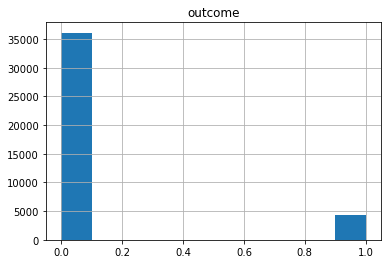

In [6]:
fig, ax = plt.subplots()
all_shots.hist(column = 'outcome', ax = ax)

In [7]:
all_shots['outcome'].sum()/all_shots.shape[0] * 100

10.569729997522913

This is an imbalanced data set where there are only 10.57 % positive labels {1 - ending with goal}. 

### Feature Engineering

Since we will generate new features in this section and populate our dataframe `all_shots` with new columns, let us remove some columns that will not be needed anymore.

In [8]:
all_shots.columns

Index(['game_id', 'period_id', 'team_id', 'player_id', 'type_id', 'type_name',
       'subtype_id', 'subtype_name', 'tag_id', 'tag_name', 'x_start',
       'y_start', 'x_end', 'y_end', 'nickname', 'team_name_short', 'outcome'],
      dtype='object')

Columns: `'game_id', 'period_id', 'team_id', 'player_id', 'type_id', 'type_name', 'subtype_id', 'subtype_name'` can be removed.

In [9]:
rm_columns = np.r_[0:8] 
all_shots = all_shots.drop(columns = all_shots.columns[rm_columns])

In [10]:
all_shots.head()

,tag_id,tag_name,x_start,y_start,x_end,y_end,nickname,team_name_short,outcome
0,"[402, 201, 1206, 1801]","[right foot, opportunity, position: goal cente...",83,66,0.0,0.0,C. Tolisso,Bayern Munich,0
1,"[101, 403, 201, 1205, 1801]","[goal, head/body, opportunity, position: goal ...",95,59,0.0,0.0,N. Süle,Bayern Munich,1
2,"[402, 201, 1201, 1801]","[right foot, opportunity, position: goal low c...",91,66,100.0,100.0,A. Mehmedi,Bayer Leverkusen,0
3,"[402, 201, 1212, 1802]","[right foot, opportunity, position: out low le...",88,49,100.0,100.0,K. Bellarabi,Bayer Leverkusen,0
4,"[402, 1216, 1802]","[right foot, position: out high right, not acc...",74,42,0.0,0.0,A. Vidal,Bayern Munich,0


This looks much cleaner, so we can proceed.

There are several factors that can affect probability of shooting for a player. We will start with `distance to goal` and `angle of shot`.

In [11]:
# Distance Feature calculation

# define goal center for 'wyscout' data
goal_center = np.array([100, 50])

# calculate distance between shot and goal center
all_shots['distance'] = np.sqrt((all_shots['x_start'] - goal_center[0])**2 + (all_shots['y_start'] - goal_center[1])**2)
all_shots['distance'] = all_shots['distance'].round(decimals = 2)

In [12]:
# Angle Feature calculation

# transform x, y coordinates from percentiles to field length coordinates (105 meters x 68 meters)
x = all_shots['x_start'] * 105/100
y = all_shots['y_start'] * 68/100 

# Use trigonometric formula to find angle between two sides (a,b ) of triangle where third side (c) 
# is a goal line of length 7.32
a = np.sqrt((x - 105)**2 + (y - 30.34)**2) # length between right post and (x,y) shot coordinate
b = np.sqrt((x - 105)**2 + (y - 37.66)**2) # length between left post and (x,y) shot coordinate
c = 7.32 # goal line length
cos_alpha = (a**2 + b**2 - c**2)/(2*a*b)
cos_alpha = np.round(cos_alpha, decimals = 4)

# remember to leave angle in radians (if you want to transfer to degree multiply cos_alpha by 180/pi)
all_shots['angle'] = np.arccos(cos_alpha)

We can now run a simple logistic regression to see if our features are correlated with probabilities of scoring.

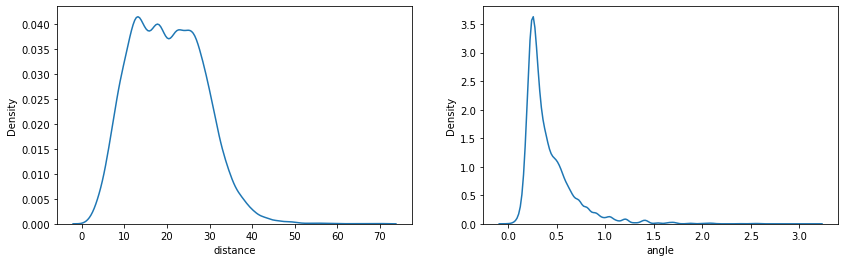

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))
sns.kdeplot(x = 'distance', data = all_shots, ax = ax[0])
sns.kdeplot(x = 'angle', data = all_shots, ax = ax[1])
plt.show()

**Splitting data**

In [348]:
from sklearn.model_selection import train_test_split
# Prepare features and labels from available data
X = all_shots[['distance', 'angle']]
y = all_shots['outcome']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [349]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

### Running Model

In [16]:
from sklearn.linear_model import LogisticRegression

# Fit Logistic Regression Model
xG_model = LogisticRegression(penalty = 'none')
xG_model.fit(X_train, y_train)


LogisticRegression(penalty='none')

In [17]:
scoring_probs = xG_model.predict_proba(X_train)[:, 1]
xG_model.predict_proba(X)

array([[0.94964518, 0.05035482],
       [0.79932723, 0.20067277],
       [0.92040317, 0.07959683],
       ...,
       [0.80674106, 0.19325894],
       [0.9667425 , 0.0332575 ],
       [0.78061425, 0.21938575]])

In [18]:
xG_model.classes_

array([0, 1], dtype=int64)

According to `.classes_` attribute we can see that the second column of predictions from our `xG_model` evaluates probability of shooting from a given `(x, y)`. Now, we visualize relation between probabilities of scoring and `distance` \ `angle` features.

Text(0.5, 1.0, 'Probabilities with different angles')

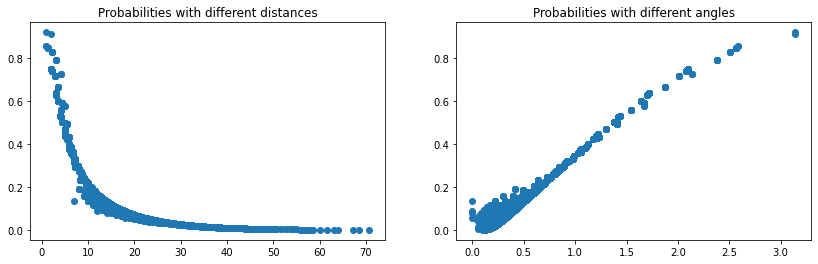

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))
ax[0].scatter(X_train['distance'], scoring_probs)
ax[0].set_title('Probabilities with different distances')
ax[1].scatter(X_train['angle'], scoring_probs)
ax[1].set_title('Probabilities with different angles')

From the above plots we can observe that there is an exponential relationship between distance to the goal and probability of scoring. With regards to the shot angle, it can be said that wider shot angles have a higher chances of scoring. These trends are further proven by the values of coefficients derived from logistic regression.

In [20]:
print("Estimated regression cofficient for `distance` feature equals = ", xG_model.coef_[0][0].round(decimals = 4))
print("Estimated regression cofficient for `angle` feature equals = ", xG_model.coef_[0][1].round(decimals = 4))

Estimated regression cofficient for `distance` feature equals =  -0.0877
Estimated regression cofficient for `angle` feature equals =  1.2046


### Statistical Analysis

Another interesting approach will be to analyze these features via statistical analysis. Here, we can use `statsmodels` package to run logistic regression on `X_train, y_train`.

In [21]:
df_train = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)

In [22]:
import statsmodels.formula.api as smf

# run model
logreg_model = smf.logit(formula = "outcome ~ distance + angle", data = df_train).fit()

Optimization terminated successfully.
         Current function value: 0.291115
         Iterations 7


In [23]:
logreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                28259
Model:                          Logit   Df Residuals:                    28256
Method:                           MLE   Df Model:                            2
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                  0.1326
Time:                        15:03:36   Log-Likelihood:                -8226.6
converged:                       True   LL-Null:                       -9484.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2499      0.139     -9.012      0.000      -1.522      -0.978
distance      -0.0877      0.005    -16.613      0.000      -0.098      -0.077
angle          1.2046      0.114     10.533      0.000       0.980       1.429
==============================================================================
"""

Statistical analysis of our features reveals that both of them are significant. Standard errors are quite small `[0.005, 0.114]`in relation with parameter values`[-0.0877, 1.2046]`. Furthermore, p-values are low what also validates that we cannot say that this features are insignificant (or null hypothesis is true) for our model.

In [24]:
logreg_model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.2499,0.139,-9.012,0.000,-1.522,-0.978
distance,-0.0877,0.005,-16.613,0.000,-0.098,-0.077
angle,1.2046,0.114,10.533,0.000,0.980,1.429


### Model Evaluation

In [25]:
# save predictions
xG_predictions = xG_model.predict_proba(X_train)[:, 1]

In [26]:
df_train = pd.concat([df_train, pd.Series(xG_predictions, name = 'xG')], axis = 1)
df_train.head()

,distance,angle,outcome,xG
0,25.08,0.221359,0,0.039836
1,26.02,0.266494,0,0.038776
2,11.70,0.585927,0,0.172219
3,23.32,0.272132,0,0.048946
4,8.94,0.761068,0,0.246569


In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# ROC curve

#def roc():
n = 100
    
df_train['simulated_outcome'] = np.zeros(shape = (df_train.shape[0], 1))
roc_matrix = np.zeros(shape = (100, 3))
thresholds = np.arange(0, 1, 1/n)
roc_matrix[:, 0] = thresholds

for i, m in enumerate(thresholds):
    df_train['simulated_outcome'] = df_train['xG'].apply(lambda x: 1 if x > m else 0)
    TN, FP, FN, TP = confusion_matrix(df_train['outcome'], df_train['simulated_outcome']).ravel()
    roc_matrix[i, 1] = FP/(TN + FP) # false positive rate
    roc_matrix[i, 2] = TP/(TP + FN) # true positive rate
    

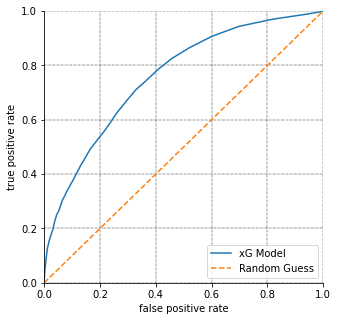

In [28]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.grid(color='black', ls = '-.', lw = 0.4, which = 'major')

#fig.set_facecolor("#092D6C")
#ax.set_facecolor('#092D6C')
ax.plot(roc_matrix[:, 1], roc_matrix[:, 2], zorder = 2)
ax.plot([0, 1], [0, 1], ls = '--')
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(labels = ['xG Model', 'Random Guess'], loc = 4,
          #bbox_to_anchor=(1.0, 0.1, 0.5, 0.5),
         frameon = True)
plt.show()


In [29]:
roc_auc_score(df_train['outcome'], df_train['xG'])
# with less shots roc_auc_train = 0.7628

0.7595946344254663

In [30]:
# save predictions
xG_preds = pd.Series(xG_model.predict_proba(X_valid)[:, 1], name = 'xG')

df_valid = pd.concat([X_valid, y_valid], axis = 1).reset_index(drop = True)

df_valid = pd.concat([df_valid, xG_preds], axis = 1)

# ROC curve

#def roc():
n = 100
    
df_valid['simulated_outcome'] = np.zeros(shape = (df_valid.shape[0], 1))
roc_matrix = np.zeros(shape = (100, 3))
thresholds = np.arange(0, 1, 1/n)
roc_matrix[:, 0] = thresholds

for i, m in enumerate(thresholds):
    df_valid['simulated_outcome'] = df_valid['xG'].apply(lambda x: 1 if x > m else 0)
    TN, FP, FN, TP = confusion_matrix(df_valid['outcome'], df_valid['simulated_outcome']).ravel()
    roc_matrix[i, 1] = FP/(TN + FP) # false positive rate
    roc_matrix[i, 2] = TP/(TP + FN) # true positive rate
    

In [31]:
roc_auc_score(df_valid['outcome'], df_valid['xG'])
# with less shots roc_auc_valid = 0.74523

0.764513349602422

### Standardizing features decreases ROC-AUC for validation set

In [195]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
stdscaler = StandardScaler()
stdscaler.fit(X_train)
X_train_std = stdscaler.transform(X_train)
X_valid_std = stdscaler.transform(X_valid)

In [243]:
X_train_std

array([[ 0.5873567 , -0.76288033],
       [ 0.69904337, -0.58485793],
       [-1.00239606,  0.67503598],
       ...,
       [ 1.64243926, -0.82622175],
       [ 1.05311387, -0.68706996],
       [-1.12952875,  0.95295774]])

In [197]:
# Fit Logistic Regression Model
xG_model_std = LogisticRegression(penalty = 'none')
xG_model_std.fit(X_train_std, y_train)

LogisticRegression(penalty='none')

In [224]:
xG_predictions = xG_model.predict_proba(X_train_std)[:, 1]
df_train_std = pd.concat([pd.DataFrame(X_train_std, columns = ['distance', 'angle']) \
                          ,y_train.reset_index(drop = True)], axis = 1)
df_train_std = pd.concat([df_train_std, pd.Series(xG_predictions, name = 'xG')], axis = 1)

In [227]:
roc_auc_score(df_train_std['outcome'], df_train_std['xG'])
# with less shots roc_auc_valid = 0.74523

0.7554020471862224

In [228]:
xG_predictions = xG_model.predict_proba(X_valid_std)[:, 1]
df_valid_std = pd.concat([pd.DataFrame(X_valid_std, columns = ['distance', 'angle']), \
                          y_valid.reset_index(drop = True)], axis = 1)
df_valid_std = pd.concat([df_valid_std, pd.Series(xG_predictions, name = 'xG')], axis = 1)

In [231]:
roc_auc_score(df_valid_std['outcome'], df_valid_std['xG'])
# with less shots roc_auc_valid = 0.74523

0.7597674386788178

### Adding other features

When considering different features that can affect probability of scoring we can assess if the shot is made with right/left foot or header/body.

In [294]:
all_shots.head()

,tag_id,tag_name,x_start,y_start,x_end,y_end,nickname,team_name_short,outcome,distance,angle,body_part
0,"[402, 201, 1206, 1801]","[right foot, opportunity, position: goal cente...",83,66,0.0,0.0,C. Tolisso,Bayern Munich,0,23.35,0.299107,right foot
1,"[101, 403, 201, 1205, 1801]","[goal, head/body, opportunity, position: goal ...",95,59,0.0,0.0,N. Süle,Bayern Munich,1,10.30,0.639993,head_or_body
2,"[402, 201, 1201, 1801]","[right foot, opportunity, position: goal low c...",91,66,100.0,100.0,A. Mehmedi,Bayer Leverkusen,0,18.36,0.341958,right foot
3,"[402, 201, 1212, 1802]","[right foot, opportunity, position: out low le...",88,49,100.0,100.0,K. Bellarabi,Bayer Leverkusen,0,12.04,0.564044,right foot
4,"[402, 1216, 1802]","[right foot, position: out high right, not acc...",74,42,0.0,0.0,A. Vidal,Bayern Munich,0,27.20,0.256830,right foot


In [293]:
all_shots['body_part'] = all_shots['tag_id'].apply(lambda x: body_part(x))

In [290]:
# 
def body_part(x):
    if (401 in x) or (402 in x):
        return 'foot'
    elif 403 in x:
        return 'head_or_body'

In [292]:
# left, right, head
def body_part(x):
    if 401 in x:
        return 'left foot'
    elif 402 in x:
        return 'right foot'
    elif 403 in x:
        return 'head_or_body'

In [295]:
all_shots.head()

,tag_id,tag_name,x_start,y_start,x_end,y_end,nickname,team_name_short,outcome,distance,angle,body_part
0,"[402, 201, 1206, 1801]","[right foot, opportunity, position: goal cente...",83,66,0.0,0.0,C. Tolisso,Bayern Munich,0,23.35,0.299107,right foot
1,"[101, 403, 201, 1205, 1801]","[goal, head/body, opportunity, position: goal ...",95,59,0.0,0.0,N. Süle,Bayern Munich,1,10.30,0.639993,head_or_body
2,"[402, 201, 1201, 1801]","[right foot, opportunity, position: goal low c...",91,66,100.0,100.0,A. Mehmedi,Bayer Leverkusen,0,18.36,0.341958,right foot
3,"[402, 201, 1212, 1802]","[right foot, opportunity, position: out low le...",88,49,100.0,100.0,K. Bellarabi,Bayer Leverkusen,0,12.04,0.564044,right foot
4,"[402, 1216, 1802]","[right foot, position: out high right, not acc...",74,42,0.0,0.0,A. Vidal,Bayern Munich,0,27.20,0.256830,right foot


In [303]:
all_shots['dist_x_angle'] = all_shots.loc[:,'distance'] * all_shots.loc[:, 'angle']

In [304]:
all_shots.head()

,tag_id,tag_name,x_start,y_start,x_end,y_end,nickname,team_name_short,outcome,distance,angle,body_part,dist_x_angle
0,"[402, 201, 1206, 1801]","[right foot, opportunity, position: goal cente...",83,66,0.0,0.0,C. Tolisso,Bayern Munich,0,23.35,0.299107,right foot,6.984149
1,"[101, 403, 201, 1205, 1801]","[goal, head/body, opportunity, position: goal ...",95,59,0.0,0.0,N. Süle,Bayern Munich,1,10.30,0.639993,head_or_body,6.591927
2,"[402, 201, 1201, 1801]","[right foot, opportunity, position: goal low c...",91,66,100.0,100.0,A. Mehmedi,Bayer Leverkusen,0,18.36,0.341958,right foot,6.278343
3,"[402, 201, 1212, 1802]","[right foot, opportunity, position: out low le...",88,49,100.0,100.0,K. Bellarabi,Bayer Leverkusen,0,12.04,0.564044,right foot,6.791091
4,"[402, 1216, 1802]","[right foot, position: out high right, not acc...",74,42,0.0,0.0,A. Vidal,Bayern Munich,0,27.20,0.256830,right foot,6.985783


In [350]:
from sklearn.model_selection import train_test_split
# Prepare features and labels from available data
X = all_shots.loc[:, ['distance', 'angle','body_part']]
y = all_shots.loc[:, 'outcome']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [351]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [352]:
X_train

,distance,angle,body_part
38731,25.08,0.221359,right foot
1175,26.02,0.266494,left foot
13493,11.70,0.585927,head_or_body
25890,23.32,0.272132,left foot
20178,8.94,0.761068,head_or_body
...,...,...,...
6286,24.04,0.289804,left foot
11308,19.24,0.318839,right foot
38239,33.96,0.205299,right foot
862,29.00,0.240580,right foot


In [354]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
column_trans = ColumnTransformer(
    [('encode_bodyparts', OneHotEncoder(dtype='int'), ['body_part']),
    ('std_distance_angle', StandardScaler(), ['distance', 'angle'])],
    remainder = 'passthrough', verbose_feature_names_out=True)

X_train_trans = column_trans.fit_transform(X_train)

In [251]:
# Fit Logistic Regression Model
xG_model_trans = LogisticRegression(penalty = 'none')
xG_model_trans.fit(X_train_trans, y_train)

xG_predictions = xG_model_trans.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7741080003577754

In [269]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = xG_model_trans.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7769444667712129

In [287]:
ls = []
for i in all_shots.loc[:, 'tag_name']:
    ls = ls + i

**adding `dist_x_angle`feature**

In [315]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer(
    [('encode_bodyparts', OneHotEncoder(dtype='int'), ['body_part']),
    ('std_distance_angle', StandardScaler(), ['distance', 'angle', 'dist_x_angle'])],
    remainder = 'passthrough', verbose_feature_names_out=True)

X_train_trans = column_trans.fit_transform(X_train)

In [316]:
# Fit Logistic Regression Model
xG_model_trans = LogisticRegression(penalty = 'none')
xG_model_trans.fit(X_train_trans, y_train)

xG_predictions = xG_model_trans.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7741845959966297

In [317]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = xG_model_trans.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7773343776560542

**basis expansion**

In [330]:
pol = PolynomialFeatures(3)

In [333]:
#pol.fit(X_train)

In [345]:
from sklearn.preprocessing import PolynomialFeatures
column_trans = ColumnTransformer(
    [('encode_bodyparts', OneHotEncoder(dtype='int'), ['body_part']),
    ('std_distance_angle', StandardScaler(), ['distance', 'angle']),
    ('basis_expansion', PolynomialFeatures(2, interaction_only = True), ['distance', 'angle'])],
    remainder = 'passthrough', verbose_feature_names_out=True)

X_train_trans = column_trans.fit_transform(X_train)

# Fit Logistic Regression Model
xG_model_trans = LogisticRegression(penalty = 'none')
xG_model_trans.fit(X_train_trans, y_train)

xG_predictions = xG_model_trans.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7741840489802227

In [346]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = xG_model_trans.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7773377979269738

#### Different model

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
column_trans = ColumnTransformer(
    [('encode_bodyparts', OneHotEncoder(dtype='int'), ['body_part']),
    ('std_distance_angle', StandardScaler(), ['distance', 'angle'])],
    remainder = 'passthrough', verbose_feature_names_out=True)

X_train_trans = column_trans.fit_transform(X_train)

In [356]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train_trans, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [357]:
xG_predictions = classifier.predict_proba(X_train_trans)[:, 1]
roc_auc_score(y_train, xG_predictions)

0.7573051372792375

In [359]:
X_valid_trans = column_trans.transform(X_valid)
xG_predictions = classifier.predict_proba(X_valid_trans)[:, 1]
roc_auc_score(y_valid, xG_predictions)

0.7638111964848734